<a href="https://colab.research.google.com/github/Kieranosaurus/HYPER/blob/master/MXNet_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mxnet

import mxnet as mx
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from IPython import display
import matplotlib.pyplot as plt
import time

     |████████████████████████████████| 55.0MB 56kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]
('X shape: ', X.shape, 'X dtype', X.dtype, 'y:', y)

('X shape: ', (28, 28, 1), 'X dtype', numpy.uint8, 'y:', 2)

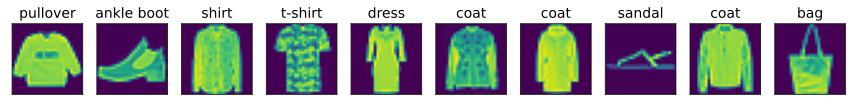

In [3]:
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
X, y = mnist_train[0:10]
# plot images
display.set_matplotlib_formats('svg')
_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])
mnist_train = mnist_train.transform_first(transformer)

In [5]:
batch_size = 256
ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()
train_data = gluon.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
for data, label in train_data:
    print(data.shape, label.shape)
    break

(256, 1, 28, 28) (256,)


In [7]:
mnist_valid = gluon.data.vision.FashionMNIST(train=False)
valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer),
    batch_size=batch_size, num_workers=4)

In [8]:
# net = nn.Sequential()
# net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
#         nn.MaxPool2D(pool_size=2, strides=2),
#         nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
#         nn.MaxPool2D(pool_size=2, strides=2),
#         nn.Flatten(),
#         nn.Dense(120, activation="relu"),
#         nn.Dense(84, activation="relu"),
#         nn.Dense(10))
# net.initialize(init=init.Xavier())

net = nn.Sequential()
encoder = nn.Sequential()
encoder.add(nn.Dense(256, activation='relu'),
            nn.Dropout(rate=0.1),
            nn.Dense(120, activation='relu'),
            nn.Dropout(rate=0.1),
            nn.Dense(10))
decoder = nn.Sequential()
decoder.add(nn.Dense(120, activation='relu'),
            nn.Dropout(rate=0.1),
            nn.Dense(256, activation='relu'),
            nn.Dropout(rate=0.1),
            nn.Dense(784, activation='relu'))
net.add(encoder,
        decoder)
net.initialize(ctx=ctx)

In [9]:
net.summary(mnist_valid.transform_first(transformer)[0][0].expand_dims(axis=0).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 1, 28, 28)               0
        Activation-1                    <Symbol dense0_relu_fwd>               0
        Activation-2                                    (1, 256)               0
             Dense-3                                    (1, 256)          200960
           Dropout-4                                    (1, 256)               0
        Activation-5                    <Symbol dense1_relu_fwd>               0
        Activation-6                                    (1, 120)               0
             Dense-7                                    (1, 120)           30840
           Dropout-8                                    (1, 120)               0
             Dense-9                                     (1, 10)            1210
       Activation-10        

In [10]:
# softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

l2_loss = gluon.loss.L2Loss()
l1_loss = gluon.loss.L1Loss()

In [11]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [12]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

In [14]:
for epoch in range(20):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time.time()
    for data, _ in train_data:
        data = data.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            # loss = softmax_cross_entropy(output, label)
            l2 = l2_loss(output.flatten(), data.flatten())
            l1 = l1_loss(output.flatten(), data.flatten())
            loss = l2 + l1
        loss.backward()
        # update parameters
        trainer.step(batch_size)
        # calculate training metrics
        train_loss += loss.mean().asscalar()
    print("Epoch %d: loss %.3f, in %.1f sec" % (
            epoch, train_loss/len(train_data), time.time()-tic))

Epoch 0: loss 1.452, in 12.2 sec
Epoch 1: loss 1.189, in 12.2 sec
Epoch 2: loss 1.167, in 12.5 sec
Epoch 3: loss 1.154, in 12.1 sec
Epoch 4: loss 1.147, in 12.2 sec
Epoch 5: loss 1.138, in 12.2 sec
Epoch 6: loss 1.059, in 12.0 sec
Epoch 7: loss 0.982, in 11.8 sec
Epoch 8: loss 0.940, in 11.7 sec
Epoch 9: loss 0.913, in 11.7 sec
Epoch 10: loss 0.898, in 11.8 sec
Epoch 11: loss 0.888, in 11.8 sec
Epoch 12: loss 0.877, in 12.0 sec
Epoch 13: loss 0.865, in 12.3 sec
Epoch 14: loss 0.856, in 12.4 sec
Epoch 15: loss 0.849, in 12.5 sec
Epoch 16: loss 0.841, in 12.3 sec
Epoch 17: loss 0.833, in 12.4 sec
Epoch 18: loss 0.827, in 12.3 sec
Epoch 19: loss 0.824, in 12.3 sec
Epoch 20: loss 0.821, in 12.0 sec
Epoch 21: loss 0.819, in 11.9 sec
Epoch 22: loss 0.815, in 12.0 sec
Epoch 23: loss 0.811, in 11.8 sec
Epoch 24: loss 0.807, in 12.0 sec
Epoch 25: loss 0.804, in 12.0 sec
Epoch 26: loss 0.800, in 11.9 sec
Epoch 27: loss 0.796, in 11.9 sec
Epoch 28: loss 0.793, in 11.9 sec
Epoch 29: loss 0.790, in

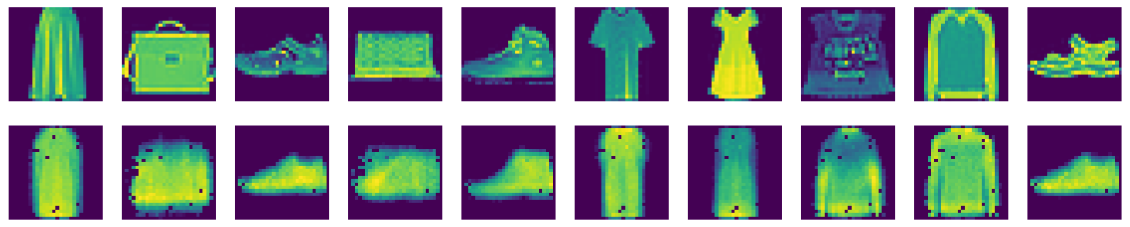

In [19]:
import random

plt.figure(figsize=(20,4))
for i in range(10):
    idx = random.randint(0, len(mnist_valid))
    img, _ = mnist_valid[idx]
    x, _ = mnist_valid.transform_first(transformer)[idx]
    output = net(x)

    ax = plt.subplot(2, 10, i+1)
    ax.imshow(x.reshape((28,28)).asnumpy())
    ax.axis('off')
    ax = plt.subplot(2, 10, 10+i+1)
    ax.imshow(output[0].reshape((28,28)).asnumpy())
    _ = ax.axis('off')

In [20]:
net.save_parameters('net.params')